In [1]:
# Importing the modules and libraries
# Additional libraries should be imported in this cell for organization

import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import autocorrelation_plot
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [3]:
# Reading the datasets and creating the dataframes

dataset = pd.read_csv("Reims_HourlyGID_2022-2023.csv", skiprows=10, skipfooter=10)
df_Reims = pd.DataFrame(dataset)

dataset = pd.read_csv("Compiegne_HourlyGID_2022-2023.csv", skiprows=10, skipfooter=10)
df_Compiegne = pd.DataFrame(dataset)

print(df_Reims.head())

print(df_Compiegne.head())

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_21580\1492570160.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  dataset = pd.read_csv("Reims_HourlyGID_2022-2023.csv", skiprows=10, skipfooter=10)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_21580\1492570160.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  dataset = pd.read_csv("Compiegne_HourlyGID_2022-2023.csv", skiprows=10, skipfooter=10)


            time    P  G(i)  H_sun   T2m  WS10m  Int
0  20220101:0010  0.0   0.0    0.0  9.63   2.00  0.0
1  20220101:0110  0.0   0.0    0.0  9.86   1.86  0.0
2  20220101:0210  0.0   0.0    0.0  9.86   1.72  0.0
3  20220101:0310  0.0   0.0    0.0  9.91   1.59  0.0
4  20220101:0410  0.0   0.0    0.0  9.85   1.86  0.0
            time    P  G(i)  H_sun    T2m  WS10m  Int
0  20220101:0010  0.0   0.0    0.0  10.99   2.55  0.0
1  20220101:0110  0.0   0.0    0.0  11.01   2.41  0.0
2  20220101:0210  0.0   0.0    0.0  11.09   2.21  0.0
3  20220101:0310  0.0   0.0    0.0  11.05   2.14  0.0
4  20220101:0410  0.0   0.0    0.0  10.80   2.34  0.0


# Explanations of the Variables
<b>P:</b> PV system power (W) <br>
<b>G(i):</b> Global irradiance on the inclined plane (plane of the array) (W/m2) <br>
<b>H_sun:</b> Sun height (degree) <br>
<b>T2m:</b> 2-m air temperature (degree Celsius) <br>
<b>WS10m:</b> 10-m total wind speed (m/s) <br>
<b>Int:</b> 1 means solar radiation values are reconstructed

In [4]:
df_Reims

time    P  G(i)  H_sun   T2m  WS10m  Int
0      20220101:0010  0.0   0.0    0.0  9.63   2.00  0.0
1      20220101:0110  0.0   0.0    0.0  9.86   1.86  0.0
2      20220101:0210  0.0   0.0    0.0  9.86   1.72  0.0
3      20220101:0310  0.0   0.0    0.0  9.91   1.59  0.0
4      20220101:0410  0.0   0.0    0.0  9.85   1.86  0.0
...              ...  ...   ...    ...   ...    ...  ...
17515  20231231:1910  0.0   0.0    0.0  8.23   7.03  0.0
17516  20231231:2010  0.0   0.0    0.0  8.03   6.83  0.0
17517  20231231:2110  0.0   0.0    0.0  7.78   6.62  0.0
17518  20231231:2210  0.0   0.0    0.0  7.53   6.69  0.0
17519  20231231:2310  0.0   0.0    0.0  7.22   6.55  0.0

[17520 rows x 7 columns]

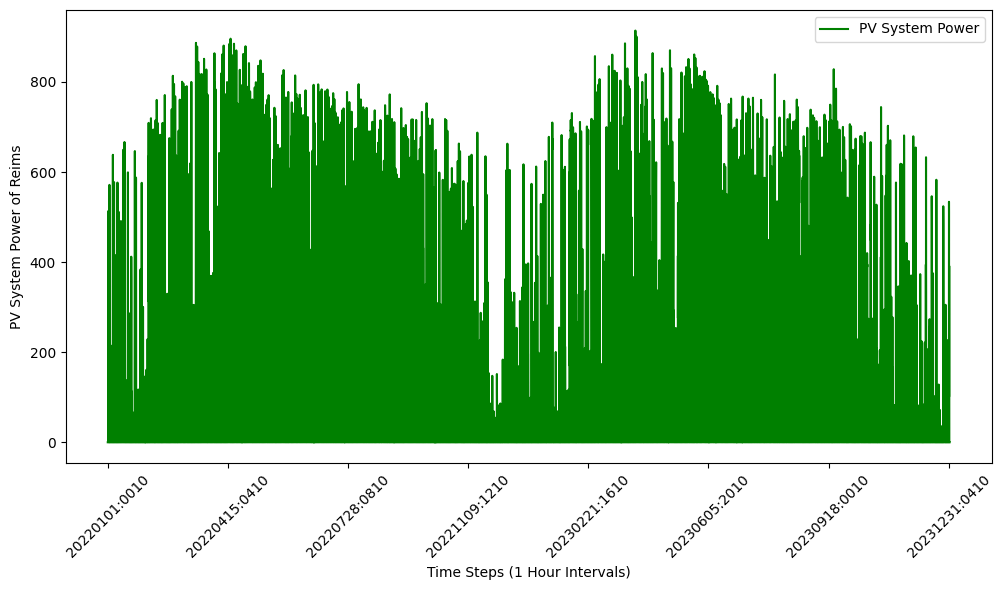

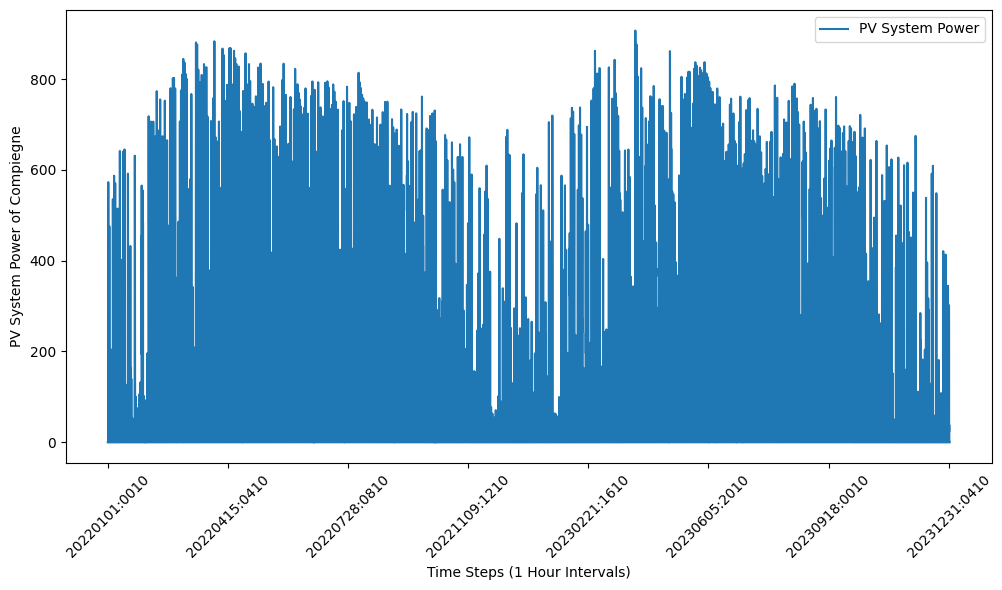

In [5]:
# Line plot of PV system power with respect to time

# Plot the line chart
ax = df_Reims.plot(x='time', y='P', label='PV System Power', kind='line', figsize=(10, 6), color='g')

# Adjust x-axis ticks to display fewer labels
xtick_positions = ax.get_xticks()  # Get the default tick positions

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('PV System Power of Reims')
plt.show()

# Plot the line chart
ax = df_Compiegne.plot(x='time', y='P', label='PV System Power', kind='line', figsize=(10, 6))

# Adjust x-axis ticks to display fewer labels
xtick_positions = ax.get_xticks()  # Get the default tick positions

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('PV System Power of Compiegne')
plt.show()

The time data can be separated into 'years' and 'hours', but the LSTM model already takes the data as a sequential sample, so the time data will be dropped during the training.

# Training the Model
The model will be trained on the Reims PV system power data, and then utilized to predict the Compiegne PV system power data.

In [4]:
df_Reims_PV = df_Reims.iloc[:, [1]]

df_Compiegne_PV = df_Compiegne.iloc[:, [1]]

df_Reims_PV

P
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
...    ...
17515  0.0
17516  0.0
17517  0.0
17518  0.0
17519  0.0

[17520 rows x 1 columns]

In [12]:
# Preparing dataset for LSTM training

df_lstm = df_Reims_PV.values
df_lstm = df_lstm.astype('float32')

In [13]:
# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm = scaler.fit_transform(df_lstm)

In [14]:
# Split into train and test sets

train_size = int(len(df_lstm) * 0.80) # Splitting into 80% and 20%
test_size = len(df_lstm) - train_size
train, test = df_lstm[0:train_size,:], df_lstm[train_size:len(df_lstm),:]
print(len(train), len(test))

14016 3504


In [15]:
# Convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [16]:
# Reshape into X=t and Y=t+1

look_back = 10 # Predicting the next value based on how many previous values
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [17]:
# Reshape input to be [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [18]:
np.shape(trainX)

(14005, 1, 10)

In [19]:
# Create and fit the LSTM network

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=10, verbose=2)

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
1401/1401 - 8s - 6ms/step - loss: 0.0198
Epoch 2/200
1401/1401 - 5s - 3ms/step - loss: 0.0105
Epoch 3/200
1401/1401 - 5s - 3ms/step - loss: 0.0097
Epoch 4/200
1401/1401 - 4s - 3ms/step - loss: 0.0095
Epoch 5/200
1401/1401 - 5s - 3ms/step - loss: 0.0093
Epoch 6/200
1401/1401 - 6s - 4ms/step - loss: 0.0092
Epoch 7/200
1401/1401 - 6s - 4ms/step - loss: 0.0092
Epoch 8/200
1401/1401 - 4s - 3ms/step - loss: 0.0091
Epoch 9/200
1401/1401 - 4s - 3ms/step - loss: 0.0090
Epoch 10/200
1401/1401 - 4s - 3ms/step - loss: 0.0089
Epoch 11/200
1401/1401 - 4s - 3ms/step - loss: 0.0088
Epoch 12/200
1401/1401 - 5s - 3ms/step - loss: 0.0088
Epoch 13/200
1401/1401 - 5s - 4ms/step - loss: 0.0087
Epoch 14/200
1401/1401 - 4s - 3ms/step - loss: 0.0087
Epoch 15/200
1401/1401 - 5s - 3ms/step - loss: 0.0086
Epoch 16/200
1401/1401 - 5s - 3ms/step - loss: 0.0086
Epoch 17/200
1401/1401 - 4s - 3ms/step - loss: 0.0086
Epoch 18/200
1401/1401 - 5s - 4ms/step - loss: 0.0085
Epoch 19/200
1401/1401 - 5s - 3ms/ste

In [20]:
# Make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train Score: 81.68 RMSE
Test Score: 81.86 RMSE


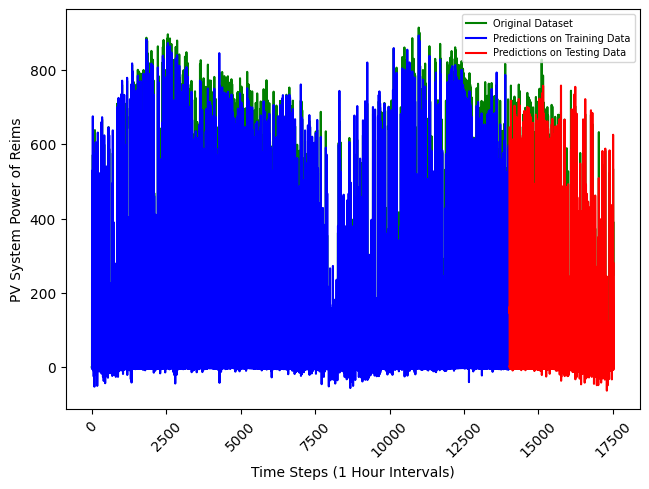

In [21]:
# Shift train predictions for plotting

trainPredictPlot = np.empty_like(df_lstm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting

testPredictPlot = np.empty_like(df_lstm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df_lstm)-1, :] = testPredict

# Plot baseline and predictions

plt.plot(scaler.inverse_transform(df_lstm), 'g', label='Original Dataset')
plt.plot(trainPredictPlot, 'b', label='Predictions on Training Data')
plt.plot(testPredictPlot, 'r', label='Predictions on Testing Data')
plt.legend(fontsize=7)

# Adjust x-axis ticks to display fewer labels
xtick_positions = ax.get_xticks()  # Get the default tick positions

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('PV System Power of Reims')
plt.show()

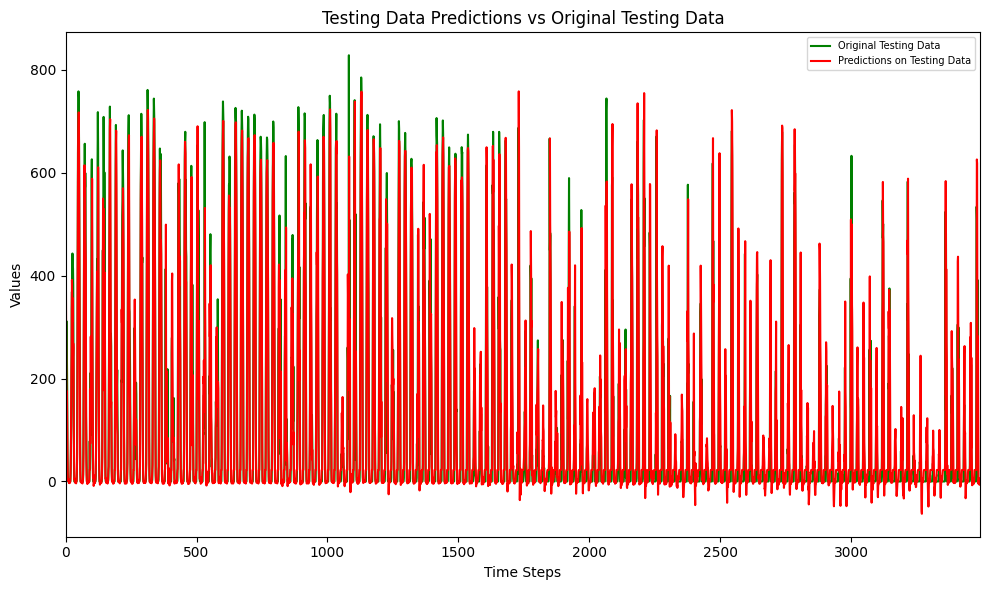

In [22]:
# Looking at the testing data closer

# Define the start and end of the testing data
test_start = len(trainPredict) + (look_back * 2) + 1
test_end = len(df_lstm) - 1

# Extract the original testing data
original_test_data = scaler.inverse_transform(df_lstm)[test_start:test_end]

# Shift test predictions for plotting
testPredictPlot = np.empty_like(df_lstm)
testPredictPlot[:, :] = np.nan
testPredictPlot[test_start:test_end, :] = testPredict

# Plot only the testing predictions and original testing data
plt.figure(figsize=(10, 6))  # Adjust figure size for clarity
plt.plot(original_test_data, 'g', label='Original Testing Data')  # Original test data
plt.plot(testPredict, 'r', label='Predictions on Testing Data')   # Test predictions

# Zoom in on the testing portion
plt.xlim(0, len(original_test_data))  # Limit x-axis to the testing range
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.title("Testing Data Predictions vs Original Testing Data")
plt.legend(fontsize=7)
plt.tight_layout()
plt.show()

# Testing the Model on the Compiegne Data

In [23]:
# Preparing dataset for LSTM training

df_lstm = df_Compiegne_PV.values
df_lstm = df_lstm.astype('float32')

In [24]:
# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm = scaler.fit_transform(df_lstm)

In [25]:
# Reshape into X=t and Y=t+1

look_back = 10 # Predicting the next value based on how many previous values
testX, testY = create_dataset(df_lstm, look_back)

In [26]:
# Reshape input to be [samples, time steps, features]

testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [27]:
np.shape(testX)

(17509, 1, 10)

In [28]:
# Make predictions

testPredict = model.predict(testX)

# Invert predictions

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error

testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test Score: 80.96 RMSE


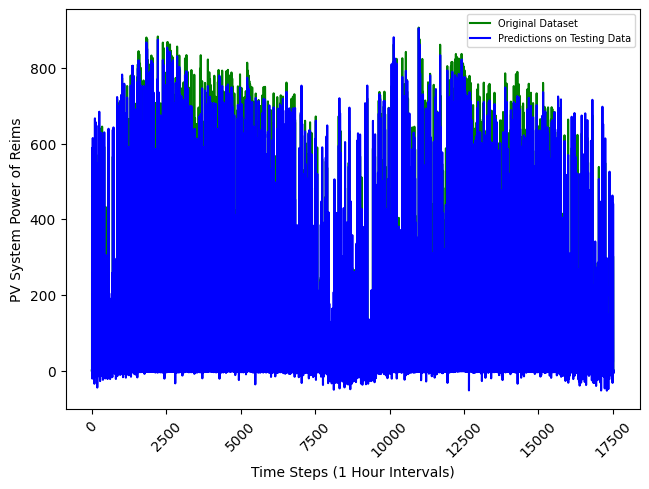

In [31]:
# Shift test predictions for plotting

testPredictPlot = np.empty_like(df_lstm)
testPredictPlot[:, :] = np.nan
testPredictPlot[look_back:len(testPredict)+look_back, :] = testPredict

# Plot baseline and predictions

plt.plot(scaler.inverse_transform(df_lstm), 'g', label='Original Dataset')
plt.plot(testPredictPlot, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

# Adjust x-axis ticks to display fewer labels
xtick_positions = ax.get_xticks()  # Get the default tick positions

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('PV System Power of Reims')
plt.show()

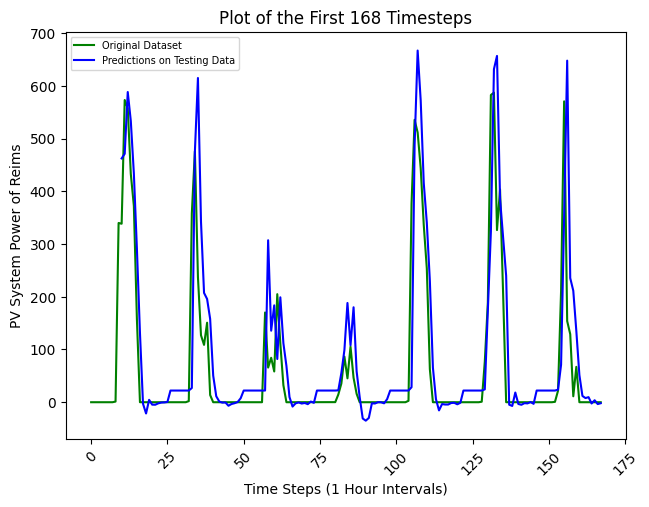

In [32]:
# Shift test predictions for plotting

testPredictPlot = np.empty_like(df_lstm)
testPredictPlot[:, :] = np.nan
testPredictPlot[look_back:len(testPredict)+look_back, :] = testPredict

# Plot baseline and predictions

# Plot baseline and predictions for the first 168 timesteps
plt.plot(scaler.inverse_transform(df_lstm)[:168], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(testPredictPlot[:168], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('PV System Power of Reims')
plt.title('Plot of the First 168 Timesteps')
plt.show()

# Multiple Feature Prediction of Reims

In [43]:
df_Reims_copy = df_Reims
df_Reims_copy

time    P  G(i)  H_sun   T2m  WS10m  Int
0      20220101:0010  0.0   0.0    0.0  9.63   2.00  0.0
1      20220101:0110  0.0   0.0    0.0  9.86   1.86  0.0
2      20220101:0210  0.0   0.0    0.0  9.86   1.72  0.0
3      20220101:0310  0.0   0.0    0.0  9.91   1.59  0.0
4      20220101:0410  0.0   0.0    0.0  9.85   1.86  0.0
...              ...  ...   ...    ...   ...    ...  ...
17515  20231231:1910  0.0   0.0    0.0  8.23   7.03  0.0
17516  20231231:2010  0.0   0.0    0.0  8.03   6.83  0.0
17517  20231231:2110  0.0   0.0    0.0  7.78   6.62  0.0
17518  20231231:2210  0.0   0.0    0.0  7.53   6.69  0.0
17519  20231231:2310  0.0   0.0    0.0  7.22   6.55  0.0

[17520 rows x 7 columns]

In [44]:
value = 1.0
 
result = df_Reims_copy[df_Reims_copy['Int'] == value]
 
print(result)

Empty DataFrame
Columns: [time, P, G(i), H_sun, T2m, WS10m, Int]
Index: []


In [45]:
# We can drop the time and int colums
# Time is dropped because the data is already sequential
# Int is dropped because it is 0 for every row

df_Reims_dropped = df_Reims_copy.drop(['Int'], axis=1)
df_Reims_dropped = df_Reims_dropped.drop(['time'], axis=1)

df_Reims_dropped

P  G(i)  H_sun   T2m  WS10m
0      0.0   0.0    0.0  9.63   2.00
1      0.0   0.0    0.0  9.86   1.86
2      0.0   0.0    0.0  9.86   1.72
3      0.0   0.0    0.0  9.91   1.59
4      0.0   0.0    0.0  9.85   1.86
...    ...   ...    ...   ...    ...
17515  0.0   0.0    0.0  8.23   7.03
17516  0.0   0.0    0.0  8.03   6.83
17517  0.0   0.0    0.0  7.78   6.62
17518  0.0   0.0    0.0  7.53   6.69
17519  0.0   0.0    0.0  7.22   6.55

[17520 rows x 5 columns]

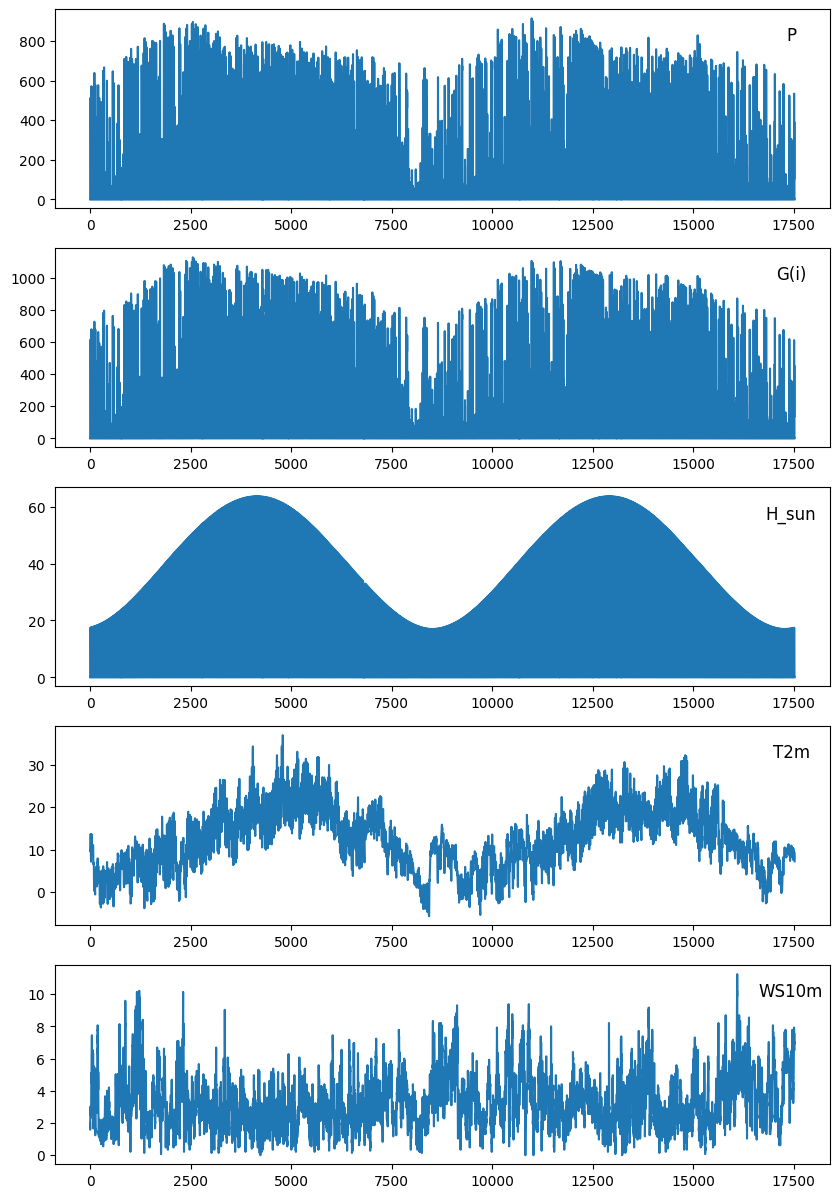

In [46]:
# Creating separate subplots for each series
values = df_Reims_dropped.values

# Specify columns to plot
groups = [0, 1, 2, 3, 4]
i = 1

# Plot each column
plt.figure(figsize=(10, 15))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df_Reims_dropped.columns[group], y=0.8, x=0.95)
	i += 1
plt.show()

In [47]:
# Splitting the dataset into training and testing sets
test_split=round(len(df_Reims_dropped)*0.20)
df_for_training=df_Reims_dropped[:-test_split]
df_for_testing=df_Reims_dropped[-test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

(14016, 5)
(3504, 5)


In [48]:
# Normalizing the values
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.        , 0.        , 0.        , 0.35967175, 0.19588639],
       [0.        , 0.        , 0.        , 0.36506448, 0.18217434],
       [0.        , 0.        , 0.        , 0.36506448, 0.16846229],
       ...,
       [0.        , 0.        , 0.        , 0.49706917, 0.22331048],
       [0.        , 0.        , 0.        , 0.4869871 , 0.21645446],
       [0.        , 0.        , 0.        , 0.47104338, 0.22331048]])

In [49]:
# Creating the training and testing datasets

def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

look_back = 72

trainX,trainY=createXY(df_for_training_scaled,look_back)
testX,testY=createXY(df_for_testing_scaled,look_back)

In [50]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (13944, 72, 5)
trainY Shape--  (13944,)


In [51]:
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

print("trainX[0]-- \n",trainX[0])
print("trainY[0]-- ",trainY[0])

testX Shape--  (3432, 72, 5)
testY Shape--  (3432,)
trainX[0]-- 
 [[0.         0.         0.         0.35967175 0.19588639]
 [0.         0.         0.         0.36506448 0.18217434]
 [0.         0.         0.         0.36506448 0.16846229]
 [0.         0.         0.         0.36623681 0.15572968]
 [0.         0.         0.         0.36483001 0.18217434]
 [0.         0.         0.         0.36271981 0.21645446]
 [0.         0.         0.         0.36131301 0.24975514]
 [0.         0.         0.         0.36576788 0.18903036]
 [0.00324931 0.01064567 0.05038456 0.36576788 0.21645446]
 [0.11246773 0.11950847 0.15366504 0.37162954 0.24289912]
 [0.22787843 0.225095   0.22932036 0.389449   0.26346719]
 [0.32419807 0.3146642  0.27122901 0.4091442  0.29676787]
 [0.5617369  0.54624072 0.27546696 0.43235639 0.29089128]
 [0.49939828 0.48701921 0.24140637 0.45017585 0.26346719]
 [0.39702858 0.38847356 0.17250039 0.45463072 0.25661117]
 [0.09925167 0.11011471 0.07455658 0.43798359 0.25661117]
 [0.  

In [52]:
# Building the model

def build_model(optimizer):

    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(trainX.shape[1],trainX.shape[2])))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model('adam'),verbose=1)

parameters = {'batch_size' : [24], 'epochs' : [50], 'optimizer' : ['adam']}

grid_search  = GridSearchCV(estimator = grid_model, param_grid = parameters, cv=2) # Hyperparameter tuning to find the best parameters

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [53]:
grid_search = grid_search.fit(trainX,trainY) # Finding the best estimator to train the model

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step - loss: 0.0284
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 30s 102ms/step - loss: 0.0114
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 30s 101ms/step - loss: 0.0097
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - loss: 0.0092
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - loss: 0.0087
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - loss: 0.0082
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 30s 102ms/step - loss: 0.0081
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - loss: 0.0080
Epoch 9/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - loss: 0.0079
Epoch 10/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - loss: 0.0076
Epoch 11/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - loss: 0.0077
Epoch 12/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - loss: 0.0077
Epoch 13/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - loss: 0.0075
Epoch 14/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 30s 102ms/step - loss: 0.0076
Epoch 15/50
291/291 

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


291/291 ━━━━━━━━━━━━━━━━━━━━ 32s 102ms/step - loss: 0.0371
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - loss: 0.0132
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 29s 98ms/step - loss: 0.0103
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - loss: 0.0093
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - loss: 0.0086
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 29s 98ms/step - loss: 0.0082
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 30s 101ms/step - loss: 0.0082
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 30s 101ms/step - loss: 0.0079
Epoch 9/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - loss: 0.0082
Epoch 10/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 31s 105ms/step - loss: 0.0079
Epoch 11/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 30s 102ms/step - loss: 0.0077
Epoch 12/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - loss: 0.0077
Epoch 13/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - loss: 0.0078
Epoch 14/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - loss: 0.0077
Epoch 15/50
291/291 ━━━━━━━━━━━

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


581/581 ━━━━━━━━━━━━━━━━━━━━ 47s 78ms/step - loss: 0.0258
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - loss: 0.0098
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 43s 75ms/step - loss: 0.0082
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 47s 81ms/step - loss: 0.0078
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 47s 81ms/step - loss: 0.0078
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 48s 82ms/step - loss: 0.0076
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 48s 82ms/step - loss: 0.0073
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 48s 82ms/step - loss: 0.0074
Epoch 9/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 46s 79ms/step - loss: 0.0074
Epoch 10/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 48s 83ms/step - loss: 0.0073
Epoch 11/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 48s 83ms/step - loss: 0.0073
Epoch 12/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 48s 83ms/step - loss: 0.0071
Epoch 13/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 43s 75ms/step - loss: 0.0072
Epoch 14/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 46s 79ms/step - loss: 0.0071
Epoch 15/50
581/581 ━━━━━━━━━━━━━━━━━━━━

In [54]:
grid_search.best_params_

{'batch_size': 24, 'epochs': 50, 'optimizer': 'adam'}

{'batch_size': 10, 'epochs': 50, 'optimizer': 'adam'}

In [55]:
my_model = grid_search.best_estimator_

In [56]:
print(my_model)

KerasRegressor(
	model=None
	build_fn=<Sequential name=sequential_1, built=True>
	warm_start=False
	random_state=None
	optimizer=adam
	loss=None
	metrics=None
	batch_size=24
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
)


In [57]:
prediction=my_model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step
prediction
 [0.00408211 0.0060475  0.00857297 ... 0.00472747 0.0043557  0.00401393]

Prediction Shape- (3432,)


In [58]:
# scaler.inverse_transform(prediction)

In [59]:
prediction_copies_array = np.repeat(prediction,5, axis=-1)

In [60]:
prediction_copies_array.shape

(17160,)

In [61]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),5)))[:,0]

In [62]:
original_copies_array = np.repeat(testY,5, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),5)))[:,0]

In [63]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [3.731215  5.527659  7.836034  ... 4.321095  3.981283  3.6688888]

Original Values--  [0. 0. 0. ... 0. 0. 0.]


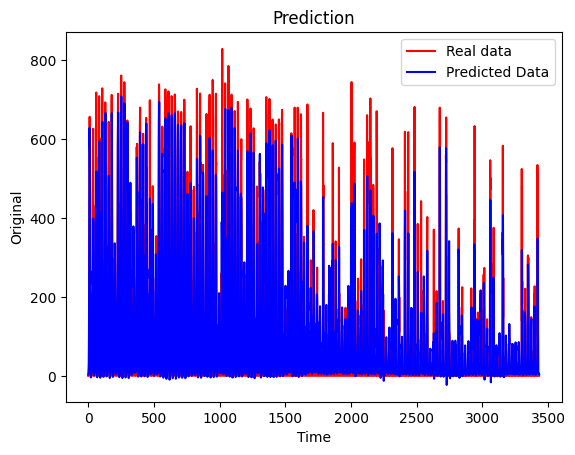

In [64]:
plt.plot(original, color = 'red', label = 'Real data')
plt.plot(pred, color = 'blue', label = 'Predicted Data')
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Original')
plt.legend()
plt.show()

# Multiple Feature Prediction of Compiegne With the Trained Model

In [65]:
df_Compiegne_copy = df_Compiegne
df_Compiegne_copy

time    P  G(i)  H_sun    T2m  WS10m  Int
0      20220101:0010  0.0   0.0    0.0  10.99   2.55  0.0
1      20220101:0110  0.0   0.0    0.0  11.01   2.41  0.0
2      20220101:0210  0.0   0.0    0.0  11.09   2.21  0.0
3      20220101:0310  0.0   0.0    0.0  11.05   2.14  0.0
4      20220101:0410  0.0   0.0    0.0  10.80   2.34  0.0
...              ...  ...   ...    ...    ...    ...  ...
17515  20231231:1910  0.0   0.0    0.0   8.51   7.17  0.0
17516  20231231:2010  0.0   0.0    0.0   8.43   7.03  0.0
17517  20231231:2110  0.0   0.0    0.0   8.31   7.10  0.0
17518  20231231:2210  0.0   0.0    0.0   8.00   6.97  0.0
17519  20231231:2310  0.0   0.0    0.0   7.82   6.83  0.0

[17520 rows x 7 columns]

In [66]:
value = 1.0
 
result = df_Compiegne_copy[df_Compiegne_copy['Int'] == value]
 
print(result)

Empty DataFrame
Columns: [time, P, G(i), H_sun, T2m, WS10m, Int]
Index: []


In [67]:
# We can drop the time and int colums
# Time is dropped because the data is already sequential
# Int is dropped because it is 0 for every row

df_Compiegne_dropped = df_Compiegne_copy.drop(['Int'], axis=1)
df_Compiegne_dropped = df_Compiegne_dropped.drop(['time'], axis=1)

df_Compiegne_dropped

P  G(i)  H_sun    T2m  WS10m
0      0.0   0.0    0.0  10.99   2.55
1      0.0   0.0    0.0  11.01   2.41
2      0.0   0.0    0.0  11.09   2.21
3      0.0   0.0    0.0  11.05   2.14
4      0.0   0.0    0.0  10.80   2.34
...    ...   ...    ...    ...    ...
17515  0.0   0.0    0.0   8.51   7.17
17516  0.0   0.0    0.0   8.43   7.03
17517  0.0   0.0    0.0   8.31   7.10
17518  0.0   0.0    0.0   8.00   6.97
17519  0.0   0.0    0.0   7.82   6.83

[17520 rows x 5 columns]

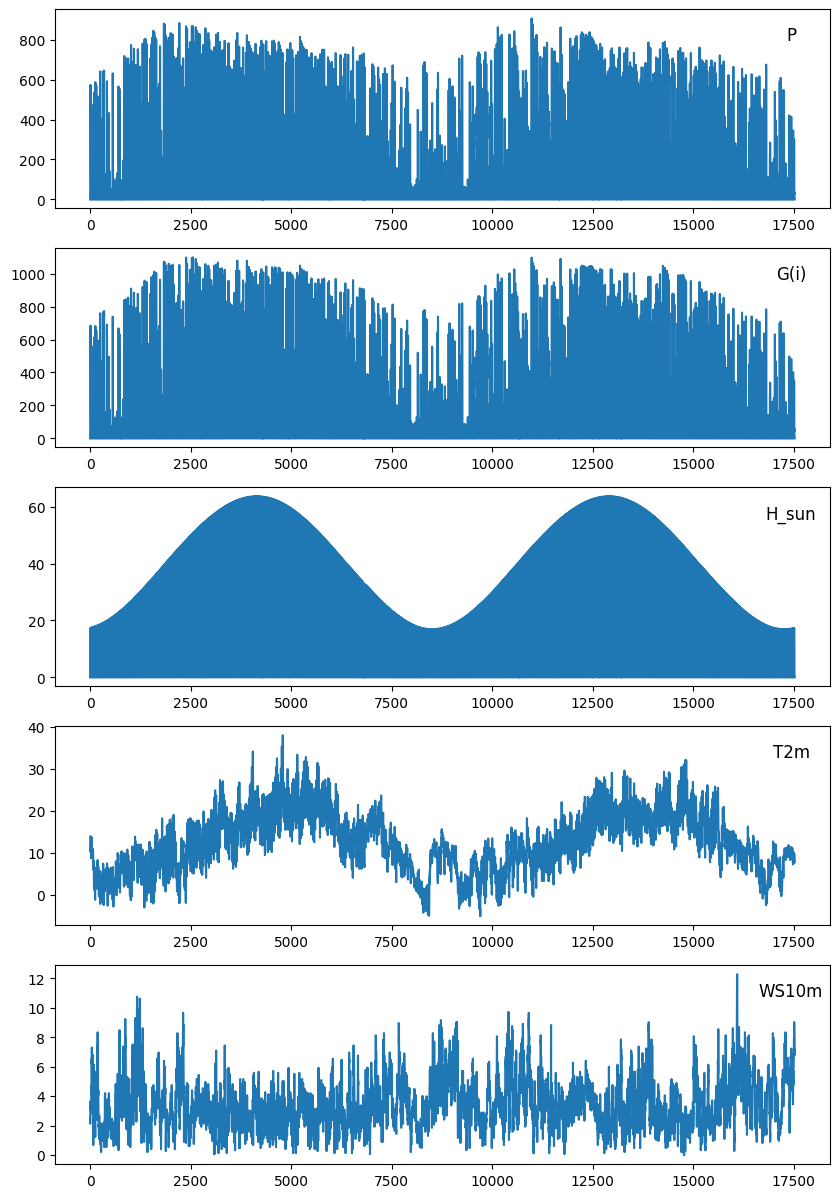

In [68]:
# Creating separate subplots for each series
values = df_Compiegne_dropped.values

# Specify columns to plot
groups = [0, 1, 2, 3, 4]
i = 1

# Plot each column
plt.figure(figsize=(10, 15))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df_Compiegne_dropped.columns[group], y=0.8, x=0.95)
	i += 1
plt.show()

In [69]:
# Splitting the dataset into training and testing sets
test_split=round(len(df_Compiegne_dropped)*0.20)
df_for_training=df_Compiegne_dropped[:-test_split]
df_for_testing=df_Compiegne_dropped[-test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

(14016, 5)
(3504, 5)


In [70]:
# Normalizing the values
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.        , 0.        , 0.        , 0.37253079, 0.23199252],
       [0.        , 0.        , 0.        , 0.37299558, 0.21889616],
       [0.        , 0.        , 0.        , 0.37485475, 0.20018709],
       ...,
       [0.        , 0.        , 0.        , 0.48710202, 0.19363891],
       [0.        , 0.        , 0.        , 0.47036951, 0.20018709],
       [0.        , 0.        , 0.        , 0.44712991, 0.21234799]])

In [71]:
# Creating the training and testing datasets

def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

look_back = 72

trainX,trainY=createXY(df_for_training_scaled,look_back)
testX,testY=createXY(df_for_testing_scaled,look_back)

In [72]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (13944, 72, 5)
trainY Shape--  (13944,)


In [73]:
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

print("trainX[0]-- \n",trainX[0])
print("trainY[0]-- ",trainY[0])

testX Shape--  (3432, 72, 5)
testY Shape--  (3432,)
trainX[0]-- 
 [[0.         0.         0.         0.37253079 0.23199252]
 [0.         0.         0.         0.37299558 0.21889616]
 [0.         0.         0.         0.37485475 0.20018709]
 [0.         0.         0.         0.37392517 0.19363891]
 [0.         0.         0.         0.36811527 0.21234799]
 [0.         0.         0.         0.36323495 0.24508887]
 [0.         0.         0.         0.35765745 0.27128157]
 [0.         0.         0.         0.37299558 0.27128157]
 [0.00134536 0.00780177 0.03955423 0.36439693 0.303087  ]
 [0.37480426 0.36632871 0.14424737 0.3660237  0.32273152]
 [0.37318321 0.36451012 0.22210014 0.38159424 0.33582788]
 [0.63192254 0.62269607 0.26667713 0.40576342 0.3292797 ]
 [0.61452107 0.60801091 0.27389735 0.4303974  0.3292797 ]
 [0.47744867 0.47124346 0.24297598 0.44248199 0.32273152]
 [0.41043426 0.40619232 0.17689531 0.44085522 0.3292797 ]
 [0.17323173 0.18295067 0.08146288 0.42505229 0.28999065]
 [0.  

In [74]:
print(my_model)

KerasRegressor(
	model=None
	build_fn=<Sequential name=sequential_1, built=True>
	warm_start=False
	random_state=None
	optimizer=adam
	loss=None
	metrics=None
	batch_size=24
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
)


In [75]:
my_model_Compiegne = my_model

In [76]:
print(my_model_Compiegne)

KerasRegressor(
	model=None
	build_fn=<Sequential name=sequential_1, built=True>
	warm_start=False
	random_state=None
	optimizer=adam
	loss=None
	metrics=None
	batch_size=24
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
)


In [77]:
prediction = my_model_Compiegne.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-", prediction.shape)

143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step
prediction
 [0.00331144 0.00542194 0.00790665 ... 0.00334933 0.0027791  0.00253636]

Prediction Shape- (3432,)


In [ ]:
# scaler.inverse_transform(prediction)

In [78]:
prediction_copies_array = np.repeat(prediction,5, axis=-1)

In [79]:
prediction_copies_array.shape

(17160,)

In [80]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),5)))[:,0]

In [81]:
original_copies_array = np.repeat(testY,5, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),5)))[:,0]

In [82]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [3.0028803 4.9167204 7.169904  ... 3.0372431 2.5201402 2.3000188]

Original Values--  [0. 0. 0. ... 0. 0. 0.]


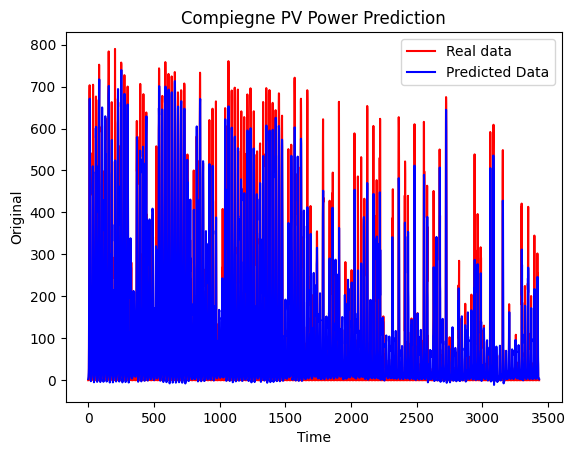

In [84]:
plt.plot(original, color = 'red', label = 'Real data')
plt.plot(pred, color = 'blue', label = 'Predicted Data')
plt.title('Compiegne PV Power Prediction')
plt.xlabel('Time')
plt.ylabel('Original')
plt.legend()
plt.show()

# Forecasting Future Values for Reims

In [27]:
df_72_days_past = df_Reims_dropped.iloc[-72:,:]
df_72_days_past.tail()

P  G(i)  H_sun   T2m  WS10m
17515  0.0   0.0    0.0  8.23   7.03
17516  0.0   0.0    0.0  8.03   6.83
17517  0.0   0.0    0.0  7.78   6.62
17518  0.0   0.0    0.0  7.53   6.69
17519  0.0   0.0    0.0  7.22   6.55

In [28]:
df_72_days_future = df_Reims_dropped.drop(['P'], axis=1)
df_72_days_future

G(i)  H_sun   T2m  WS10m
0       0.0    0.0  9.63   2.00
1       0.0    0.0  9.86   1.86
2       0.0    0.0  9.86   1.72
3       0.0    0.0  9.91   1.59
4       0.0    0.0  9.85   1.86
...     ...    ...   ...    ...
17515   0.0    0.0  8.23   7.03
17516   0.0    0.0  8.03   6.83
17517   0.0    0.0  7.78   6.62
17518   0.0    0.0  7.53   6.69
17519   0.0    0.0  7.22   6.55

[17520 rows x 4 columns]

In [29]:
df_72_days_future["P"] = 0
df_72_days_future = df_72_days_future[["P", "G(i)","H_sun","T2m","WS10m"]]

old_scaled_array = scaler.transform(df_72_days_past)
new_scaled_array = scaler.transform(df_72_days_future)

new_scaled_df = pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,0] = np.nan

full_df = pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

In [30]:
full_df

0    1    2         3         4
0      0.0  0.0  0.0  0.341618  0.547502
1      0.0  0.0  0.0  0.333880  0.554358
2      0.0  0.0  0.0  0.331536  0.554358
3      0.0  0.0  0.0  0.329894  0.554358
4      0.0  0.0  0.0  0.328957  0.547502
...    ...  ...  ...       ...       ...
17587  NaN  0.0  0.0  0.326846  0.688541
17588  NaN  0.0  0.0  0.322157  0.668952
17589  NaN  0.0  0.0  0.316295  0.648384
17590  NaN  0.0  0.0  0.310434  0.655240
17591  NaN  0.0  0.0  0.303165  0.641528

[17592 rows x 5 columns]

In [32]:
full_df_scaled_array = full_df.values
all_data  =[]
look_back = 72

for i in range(look_back, len(full_df_scaled_array)):
    data_x = []
    data_x.append(full_df_scaled_array[i-look_back :i , 0:full_df_scaled_array.shape[1]])
    data_x = np.array(data_x)
    prediction = my_model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0] = prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1

In [33]:
new_array = np.array(all_data)
new_array = new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,5, axis=-1)
y_pred_future_72_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),5)))[:,0]
print(y_pred_future_72_days)

[13.388114  18.991623  21.991676  ...  4.7316504  7.1439204 10.89118  ]


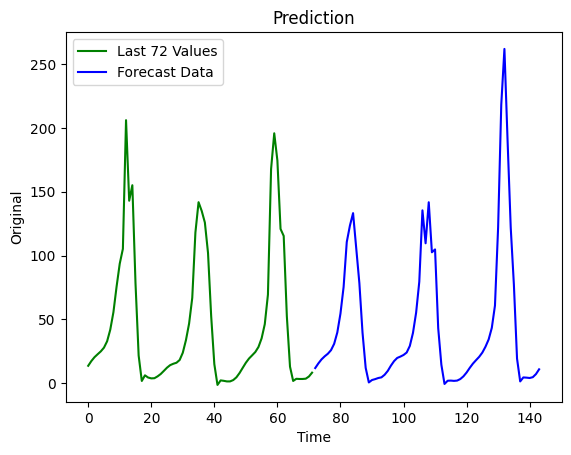

In [35]:
# Plot the last 24 values
plt.plot(range(len(y_pred_future_72_days[-144:-72,])), y_pred_future_72_days[-144:-72,], color='green', label='Last 72 Values')

# Plot the forecast data starting after the last index of the green graph
plt.plot(range(len(y_pred_future_72_days[-144:-72,]), len(y_pred_future_72_days[-144:-72,]) + len(y_pred_future_72_days[-72:,])), 
         y_pred_future_72_days[-72:,], color='blue', label='Forecast Data')

plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Original')
plt.legend()
plt.show()

# Forecasting Future Values for Compiegne

In [85]:
df_72_days_past = df_Compiegne_dropped.iloc[-72:,:]
df_72_days_past.tail()

P  G(i)  H_sun   T2m  WS10m
17515  0.0   0.0    0.0  8.51   7.17
17516  0.0   0.0    0.0  8.43   7.03
17517  0.0   0.0    0.0  8.31   7.10
17518  0.0   0.0    0.0  8.00   6.97
17519  0.0   0.0    0.0  7.82   6.83

In [86]:
df_72_days_future = df_Compiegne_dropped.drop(['P'], axis=1)
df_72_days_future

G(i)  H_sun    T2m  WS10m
0       0.0    0.0  10.99   2.55
1       0.0    0.0  11.01   2.41
2       0.0    0.0  11.09   2.21
3       0.0    0.0  11.05   2.14
4       0.0    0.0  10.80   2.34
...     ...    ...    ...    ...
17515   0.0    0.0   8.51   7.17
17516   0.0    0.0   8.43   7.03
17517   0.0    0.0   8.31   7.10
17518   0.0    0.0   8.00   6.97
17519   0.0    0.0   7.82   6.83

[17520 rows x 4 columns]

In [87]:
df_72_days_future["P"] = 0
df_72_days_future = df_72_days_future[["P", "G(i)","H_sun","T2m","WS10m"]]

old_scaled_array = scaler.transform(df_72_days_past)
new_scaled_array = scaler.transform(df_72_days_future)

new_scaled_df = pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,0] = np.nan

full_df = pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

In [88]:
full_df

0    1    2         3         4
0      0.0  0.0  0.0  0.319080  0.561272
1      0.0  0.0  0.0  0.314199  0.554724
2      0.0  0.0  0.0  0.315826  0.548176
3      0.0  0.0  0.0  0.322333  0.541628
4      0.0  0.0  0.0  0.315826  0.528531
...    ...  ...  ...       ...       ...
17587  NaN  0.0  0.0  0.314897  0.664172
17588  NaN  0.0  0.0  0.313037  0.651076
17589  NaN  0.0  0.0  0.310249  0.657624
17590  NaN  0.0  0.0  0.303044  0.645463
17591  NaN  0.0  0.0  0.298861  0.632367

[17592 rows x 5 columns]

In [89]:
full_df_scaled_array = full_df.values
all_data  =[]
look_back = 72

for i in range(look_back, len(full_df_scaled_array)):
    data_x = []
    data_x.append(full_df_scaled_array[i-look_back :i , 0:full_df_scaled_array.shape[1]])
    data_x = np.array(data_x)
    prediction = my_model_Compiegne.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0] = prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/

In [90]:
new_array = np.array(all_data)
new_array = new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,5, axis=-1)
y_pred_future_72_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),5)))[:,0]
print(y_pred_future_72_days)

[ 2.3428     7.646672  13.979966  ...  3.1014824  2.6109724  2.414809 ]


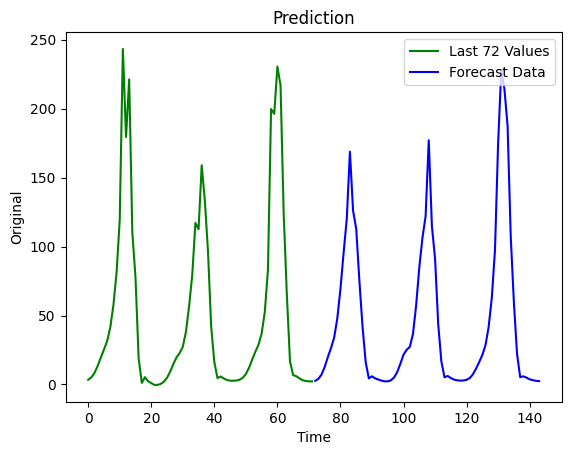

In [91]:
# Plot the last 24 values
plt.plot(range(len(y_pred_future_72_days[-144:-72,])), y_pred_future_72_days[-144:-72,], color='green', label='Last 72 Values')

# Plot the forecast data starting after the last index of the green graph
plt.plot(range(len(y_pred_future_72_days[-144:-72,]), len(y_pred_future_72_days[-144:-72,]) + len(y_pred_future_72_days[-72:,])), 
         y_pred_future_72_days[-72:,], color='blue', label='Forecast Data')

plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Original')
plt.legend()
plt.show()

# ARIMA Method for Predicting Reims PV Power

     P
0  0.0
1  0.0
2  0.0
3  0.0
4  0.0


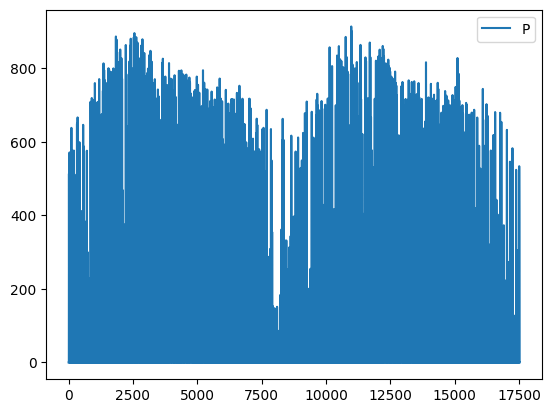

In [5]:
print(df_Reims_PV.head())

df_Reims_PV.plot()
plt.show()

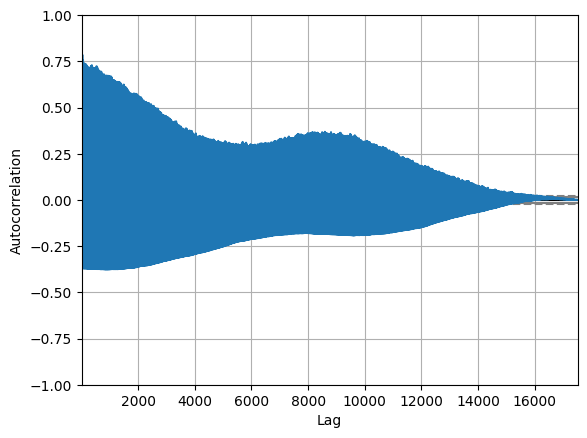

In [6]:
autocorrelation_plot(df_Reims_PV)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      P   No. Observations:                17520
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -105470.604
Date:                Tue, 21 Jan 2025   AIC                         210953.207
Time:                        10:11:44   BIC                         210999.834
Sample:                             0   HQIC                        210968.560
                              - 17520                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1403      0.004     33.746      0.000       0.132       0.148
ar.L2          0.1695      0.005     37.364      0.000       0.161       0.178
ar.L3          0.0525      0.005     11.039      0.0

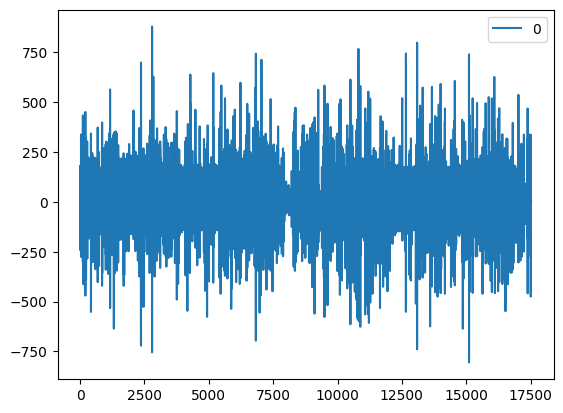

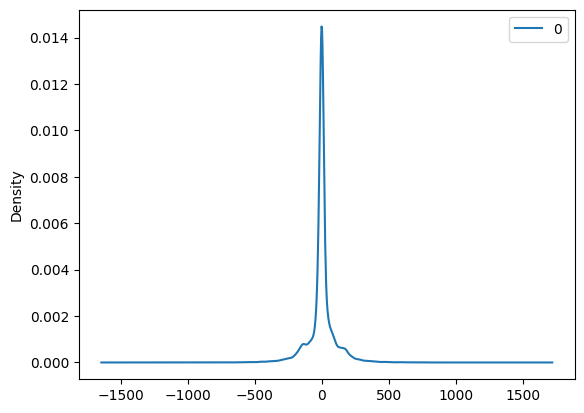

                  0
count  1.752000e+04
mean  -1.703356e-17
std    9.962489e+01
min   -8.051364e+02
25%   -1.590392e+01
50%   -1.489301e-29
75%    1.410920e+01
max    8.786950e+02


In [7]:
# fit model
model_arima = ARIMA(df_Reims_PV, order=(5,1,0))
model_fit = model_arima.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

In [8]:
# split into train and test sets
X = df_Reims_PV.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
	
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_21580\932491668.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('predicted=%f, expected=%f' % (yhat, obs))


predicted=3.223081, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=8.670000
predicted=9.947400, expected=95.320000
predicted=109.669283, expected=267.990000
predicted=309.735780, expected=403.090000
predicted=458.658337, expected=632.610000
predicted=693.429917, expected=354.740000
predicted=341.538435, expected=208.580000
predicted=121.174766, expected=138.660000
predicted=55.796140, expected=311.770000
predicted=313.354674, expected=243.120000
predicted=299.943612, expected=232.570000
predicted=247.986634, expected=167.110000
predicted=146.437488, expected=55.990000
predicted=14.343659, expected=18.280000
predicted=-3.233163, expected=0.000000
predicted=-9.719007, expected=0.000000
predicted=9.435219, expected=0.000000
predicted=13.155825, expected=0.000000
predicted=5.198072, expected=0.000000
predicted=1.875247, expected=0.00000

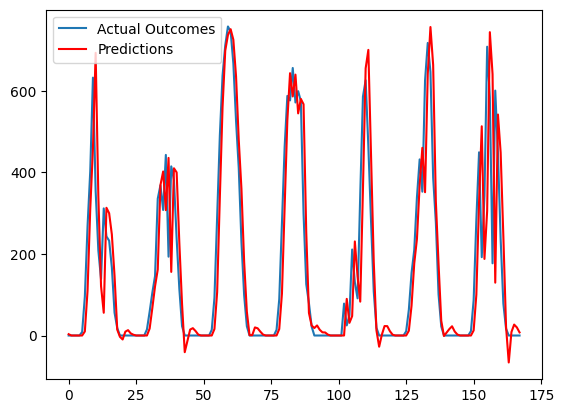

In [9]:
# plot forecasts against actual outcomes
plt.plot(test[:168], label='Actual Outcomes')
plt.plot(predictions[:168], color='red', label='Predictions')
plt.legend()
plt.show()

# ARIMA Method for Predicting Compiegne PV Power With Trained Model

     P
0  0.0
1  0.0
2  0.0
3  0.0
4  0.0


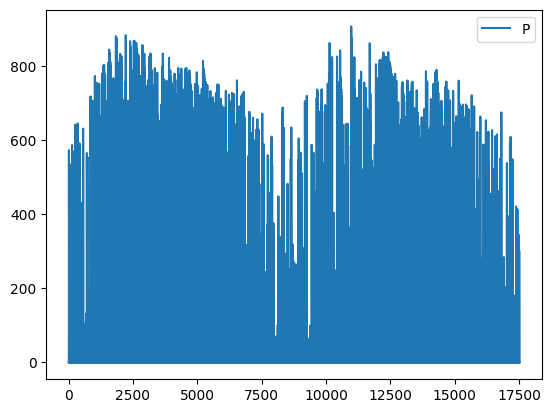

In [10]:
print(df_Compiegne_PV.head())

df_Compiegne_PV.plot()
plt.show()

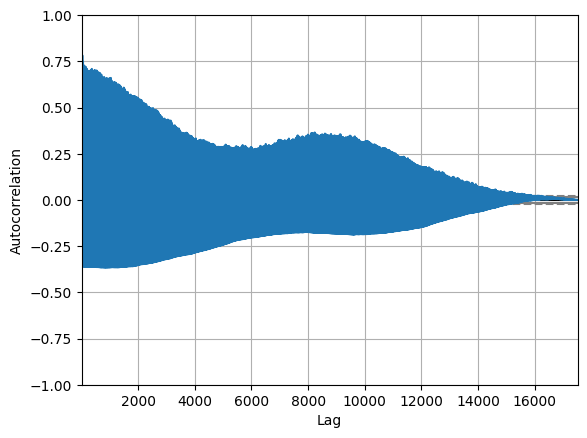

In [11]:
autocorrelation_plot(df_Compiegne_PV)
plt.show()

In [12]:
# split into train and test sets
X = df_Compiegne_PV.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
	
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_21580\2462683163.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('predicted=%f, expected=%f' % (yhat, obs))


predicted=2.814131, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=10.980000
predicted=12.740315, expected=69.900000
predicted=81.110749, expected=214.360000
predicted=247.387775, expected=419.650000
predicted=477.383984, expected=308.150000
predicted=324.422541, expected=363.690000
predicted=349.205236, expected=543.620000
predicted=553.419086, expected=476.170000
predicted=482.004614, expected=589.520000
predicted=611.272636, expected=462.690000
predicted=443.964863, expected=209.650000
predicted=138.937261, expected=146.840000
predicted=92.410466, expected=51.960000
predicted=13.018246, expected=7.260000
predicted=7.352520, expected=0.000000
predicted=15.596652, expected=0.000000
predicted=7.962930, expected=0.000000
predicted=11.047149, expected=0.000000
predicted=4.639986, expected=0.000000
predicted=0.694851, expected=0.000000
pr

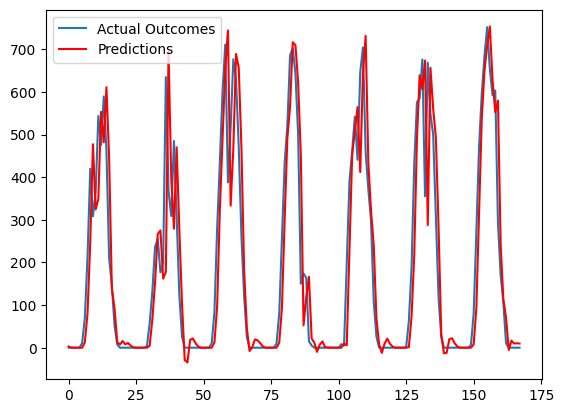

In [14]:
# plot forecasts against actual outcomes
plt.plot(test[:168], label='Actual Outcomes')
plt.plot(predictions[:168], color='red', label='Predictions')
plt.legend()
plt.show()